# SEP532 - 인공지능 이론과 실제
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## Information
**Please write your student ID and name here!**
- Student ID:
- Name:

---

## Lab #1: Dog and Cat Breed Identification (Due: May 9)

In this assignment, you are going to train a convolutional neural network to classify images of dog and cats as their breeds. Please follow the steps below to continue this assignment.

### Guidelines
Copy this example to your Google Colab and edit it to complete your assignment. We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error properly. Submissions failed to run or reproduce the results will get a substantial penalty.

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

# DO NOT EDIT THE FOLLOWING LINES
# THESE LINES ARE FOR REPRODUCIBILITY
np.random.seed(1)
tf.random.set_seed(1)

### 1. Load the Oxford-IIIT Pet dataset
In this assignment, you will use the Oxford-IIIT pet dataset which contains 37 category pet images with roughly 200 images for each class. 

![Oxford-IIIT Pet Dataset](https://storage.googleapis.com/kaggle-datasets-images/224104/481286/dd765fca1a57262c103fbfaeda98c6a3/data-original.png?t=2019-06-08-14-36-26)

Please note that the images have large variations in scale, pose and lighting. Let's import and load the Oxford-IIIT pet dataset using TensorFlow Datasets:

In [ ]:
import tensorflow_datasets as tfds

labels = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound',
    'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua',
    'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
    'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon',
    'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll',
    'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese',
    'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier',
]

dataset, metadata = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
raw_train, raw_test = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMJ1WEO/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMJ1WEO/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Let's visualize what some of these images and their corresponding training labels look like.

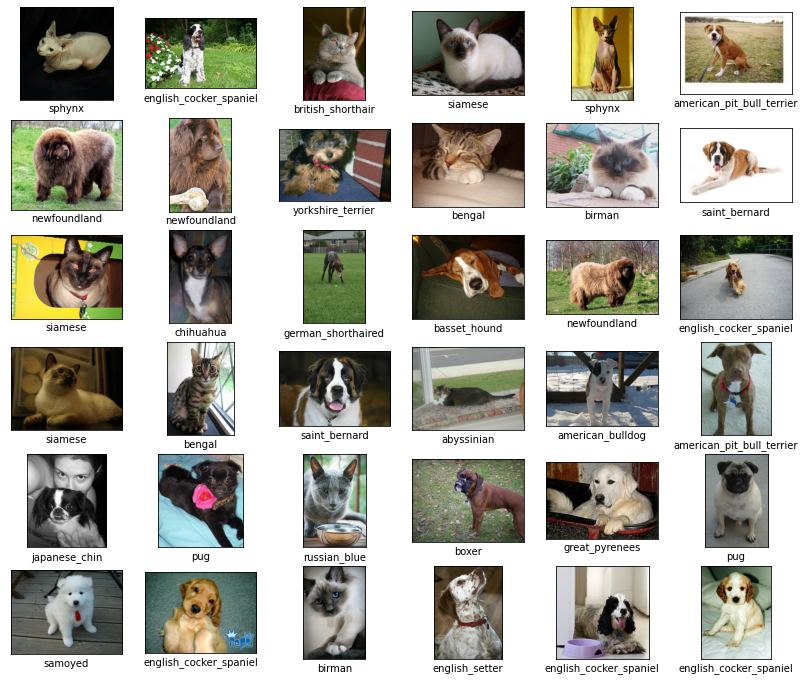

In [ ]:
plt.figure(figsize=(14, 12))

for index, (image, label) in enumerate(dataset['train'].take(36)):
    plt.subplot(6, 6, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(labels[label.numpy()])

### 2. Preprocess the dataset

#### Problem 1
Define a function to preprocess the dataset. The function should **scale the input channels** to a range of [-1, 1] and **resize the images** to a fixed size, `IMAGE_SIZE`.

In [ ]:
import tensorflow as tf

IMG_SIZE = 224
IMAGE_SHAPE = (IMG_SIZE, IMG_SIZE)

# TODO: Define a function to preprocess the dataset. 
#       The function should scale the input channels to a range of [-1, 1] and 
#                           resize the images to a fixed size, IMAGE_SHAPE
### START CODE HERE ###
def rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1  # -1~1
    image = tf.image.resize(image, IMAGE_SHAPE)
    
    return image, label
  

train = raw_train.map(rescale)
test = raw_test.map(rescale)

### END CODE HERE ###

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


#### Problem 2
Apply the defined preprocessing function to `raw_train` and `raw_test`. Then, shuffle the dataset and combine them into batches.

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

# TODO: Apply the defined preprocessing function to `raw_train` and `raw_test`
#       Then, shuffle the dataset and combine them into batches
### START CODE HERE ###
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

### END CODE HERE ###

### 3. Build the model
In this assignment, we are going to train the convolutional neural network using transfer learning.

#### Problem 3
Load `InceptionV3` model without the final classification layer using `tf.keras.applications.InceptionV3`. Then, freeze the model to prevent it from being trained.

In [ ]:
# TODO: Load InceptionV3 model without the final classification layer
#       Then, freeze the model to prevent it from being trained
### START CODE HERE ###
base_model = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False
base_model.summary()
### END CODE HERE ###

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

#### Problem 4
Define a convolutional neural network using the loaded `InceptionV3` to classify images of dogs and cats as their breeds. Then, compile your model with appropriate parameters.

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import GlobalAveragePooling2D
# TODO: Define a convolutional neural network using the loaded InceptionV3
#       Then, compile your model with appropriate parameters
### START CODE HERE ###

global_average_layer = GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(labels))

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
### END CODE HERE ###

### 4. Train the model

#### Problem 5
Now, train the model at least 10 epochs.

Epoch 1/10
115/115 [==============================] - 45s 212ms/step - loss: 0.9180 - accuracy: 0.7495
Epoch 2/10
115/115 [==============================] - 30s 223ms/step - loss: 0.2798 - accuracy: 0.9111
Epoch 3/10
115/115 [==============================] - 29s 219ms/step - loss: 0.1880 - accuracy: 0.9397
Epoch 4/10
115/115 [==============================] - 30s 225ms/step - loss: 0.1281 - accuracy: 0.9609
Epoch 5/10
115/115 [==============================] - 29s 218ms/step - loss: 0.0919 - accuracy: 0.9755
Epoch 6/10
115/115 [==============================] - 29s 219ms/step - loss: 0.0665 - accuracy: 0.9872
Epoch 7/10
115/115 [==============================] - 29s 219ms/step - loss: 0.0560 - accuracy: 0.9918
Epoch 8/10
115/115 [==============================] - 29s 215ms/step - loss: 0.0459 - accuracy: 0.9932
Epoch 9/10
115/115 [==============================] - 32s 246ms/step - loss: 0.0357 - accuracy: 0.9970
Epoch 10/10
115/115 [==============================] - 31s 235ms/step - l

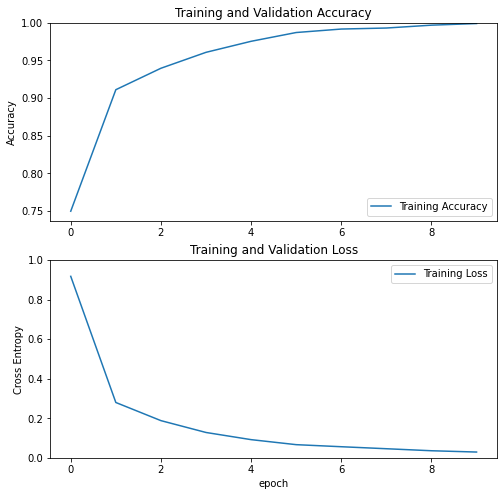

In [ ]:
# TODO: Train the model at leat 10 epochs
### START CODE HERE ###
history = model.fit(train_batches, epochs=10)

acc = history.history['accuracy']

loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
### END CODE HERE ###

#### Problem 6
To fine-tune the model, unfreeze the top layers of the model. Please note that you should carefully choose layers to be frozen. Then, compile the model again with appropriate parameters.

In [ ]:
# TODO: Unfreeze the top layers of the model
#       Compile the model with appropriate parameters
### START CODE HERE ###
fine_tune_at = 250
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

print(f"number of layers in the base model: {len(base_model.layers)}")

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
### END CODE HERE ###

number of layers in the base model: 311


#### Problem 7
Fine-tune the model at least 10 epochs.

Epoch 1/10
115/115 [==============================] - 42s 261ms/step - loss: 0.7033 - accuracy: 0.7965
Epoch 2/10
115/115 [==============================] - 34s 256ms/step - loss: 0.2068 - accuracy: 0.9353
Epoch 3/10
115/115 [==============================] - 35s 272ms/step - loss: 0.1404 - accuracy: 0.9560
Epoch 4/10
115/115 [==============================] - 35s 272ms/step - loss: 0.0904 - accuracy: 0.9723
Epoch 5/10
115/115 [==============================] - 34s 259ms/step - loss: 0.0533 - accuracy: 0.9861
Epoch 6/10
115/115 [==============================] - 34s 260ms/step - loss: 0.0691 - accuracy: 0.9791
Epoch 7/10
115/115 [==============================] - 34s 258ms/step - loss: 0.0604 - accuracy: 0.9812
Epoch 8/10
115/115 [==============================] - 36s 273ms/step - loss: 0.0688 - accuracy: 0.9774
Epoch 9/10
115/115 [==============================] - 34s 257ms/step - loss: 0.0597 - accuracy: 0.9829
Epoch 10/10
115/115 [==============================] - 35s 269ms/step - l

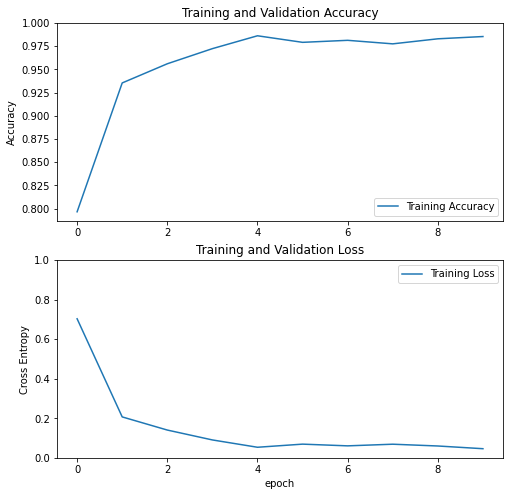

In [ ]:
# TODO: Fine-tune the model at least 10 epochs
### START CODE HERE ###
history_fine = model.fit(train_batches, epochs=10)

acc = history_fine.history['accuracy']

loss = history_fine.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
### END CODE HERE ###

### 4. Evaluate accuracy

#### Problem 8
Evaluate the trained model using test dataset and print the test accuracy of the model.

In [ ]:
# TODO: Evaluate the model using test dataset
### START CODE HERE ###
test_loss, test_acc = model.evaluate(test_batches, verbose=2)
print('\nTest accuracy:', test_acc)
### END CODE HERE ###

115/115 - 28s - loss: 0.7909 - accuracy: 0.8536 - 28s/epoch - 248ms/step

Test accuracy: 0.8536385893821716


### Extra points
TAs will rank the submissions based on the test accuracy and assign extra points according to the rank.